## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import necessary libraries

In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Calibrate camera

#### Object Points And Image Points Saved in Sandbox

In [2]:
calibration = pickle.load(open('camera_calibration.p','rb'))

imgpoints = calibration['imgpoints']
objpoints = calibration['objpoints']

## Image Processing

#### Includes methods such as
* undistort
* sobel
* gradient magnitude
* gradient direction
* hls colorspace
* region of interest

In [3]:
# Define a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Perspective Transform

In [4]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    #print(img_size)
    
    #Four source coordinates
    src = np.float32(
        [[200,img_size[1]],
         [575,450],
         [750,450],
         [1200,img_size[1]]])
    
    dst = np.float32(
        [[320,img_size[1]],
         [210,0],
         [1300,0],
         [970,img_size[1]]])
    
    #Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_AREA)
    
    return warped, M, Minv

## Detect lanes using sliding windows

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img, left_fitx, right_fitx, ploty

## Calculate curvature

In [6]:
def measure_curvature(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane line
    # Fit new polynomials to x,y in world space
    # Utilize `ym_per_pix` & `xm_per_pix` here
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = (1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**(3/2) / np.abs(2 * left_fit_cr[0])
    right_curverad = (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**(3/2) / np.abs(2 * right_fit_cr[0])
    
    return left_curverad, right_curverad

## Calculate offset

In [7]:
def measure_offset(undistorted, ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane line
    # Fit new polynomials to x,y in world space
    # Utilize `ym_per_pix` & `xm_per_pix` here
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_max = undistorted.shape[0] * ym_per_pix
    x_max = undistorted.shape[1] * xm_per_pix
    
    # Calculate offset
    left = left_fit_cr[0]*y_max**2 + left_fit_cr[1]*y_max + left_fit_cr[2]
    right = right_fit_cr[0]*y_max**2 + right_fit_cr[1]*y_max + right_fit_cr[2]
    mid = left + (right - left) / 2.0
    offset = mid - x_max / 2.0
    
    return offset

## Highlight detected lane boundaries

In [8]:
def highlight_lane(undist, warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Overlay lane curvature and vehicle offset

In [9]:
def overlay(highlighted, curvature, vehicle_offset):
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    color = (255, 255, 255)
    
    cv2.putText(img=highlighted, text='Radius of Curvature: {:.0f}(m)'.format(curvature), 
                org=(50, 50), fontFace=fontFace, fontScale=fontScale, color=color)
    
    direction = 'left' if vehicle_offset < 0 else 'right'
    cv2.putText(img=highlighted, text='Vehicle is {:.2f}m {} of center'.format(abs(vehicle_offset), direction),
               org=(50, 105), fontFace=fontFace, fontScale=fontScale, color=color)
    
    return highlighted

## Build pipeline for video processing

In [14]:
def pipeline(image):
    #img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    
    undistorted = cal_undistort(image, objpoints, imgpoints)
    
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    
    # Extract white [H, L, S]
    whitemask = cv2.inRange(hls, np.array([0, 200, 0]), np.array([255,255,255]))
    
    # Extract yellow [H, L, S]
    yellowmask = cv2.inRange(hls, np.array([20,25,100]), np.array([25, 225, 255]))
    
    combined = np.zeros_like(whitemask)
    combined[((whitemask == 255) | (yellowmask == 255))] = 255
    
    # From Project 1
    vertices = np.array([[(0,undistorted.shape[0]),(550, 300), (730, 300), (undistorted.shape[1],undistorted.shape[0])]], dtype=np.int32)
    
    image_region = region_of_interest(combined, vertices)

    # Warp this binary image
    warped_img, M, Minv = warp(combined)
    
    # Find our lane lines and return fitted polynomials
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_img)
    
    # Calculate / Measure our lane curvature in real world space (in meters)
    left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
    
    # Calculate / Measure our vehicle offset
    vehicle_offset = measure_offset(undistorted, ploty, left_fitx, right_fitx)
    
    # Take our laneline polynomials and use them along with an inverse perspective 
    # transform to highlight our lane on our undistorted image
    highlighted_image = highlight_lane(undistorted, warped_img, left_fitx, right_fitx, ploty, Minv)
    
    # Overlay lane curvature and vehicle offset
    overlay(highlighted_image, left_curverad, vehicle_offset)
    
    return highlighted_image


def pipeline2(image):
    #img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    
    undistorted = cal_undistort(image, objpoints, imgpoints)
        
    # Choose a Sobel kernel size
    ksize = 11 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(undistorted, sobel_kernel=9, thresh=(30, 100))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(undistorted, thresh=(100, 255))

    # From Project 1
    vertices = np.array([[(0,undistorted.shape[0]),(500, 425), (780, 425), (undistorted.shape[1],undistorted.shape[0])]], dtype=np.int32)
    #image_region = region_of_interest(dir_binary, vertices)
    
    #combined[(combined == 255) & (image_region == 255)] = 255
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((hls_binary == 1) & (dir_binary == 1)))] = 255
    
    image_region = region_of_interest(combined, vertices)

    # Warp this binary image
    warped_img, M, Minv = warp(image_region)
    
    # Find our lane lines and return fitted polynomials
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_img)
    
    # Calculate / Measure our lane curvature in real world space (in meters)
    left_curverad, right_curverad = measure_curvature(ploty, left_fitx, right_fitx)
    
    # Calculate / Measure our vehicle offset
    vehicle_offset = measure_offset(undistorted, ploty, left_fitx, right_fitx)
    
    # Take our laneline polynomials and use them along with an inverse perspective 
    # transform to highlight our lane on our undistorted image
    highlighted_image = highlight_lane(undistorted, warped_img, left_fitx, right_fitx, ploty, Minv)
    
    # Overlay lane curvature and vehicle offset
    overlay(highlighted_image, left_curverad, vehicle_offset)
    
    return highlighted_image

## Test image

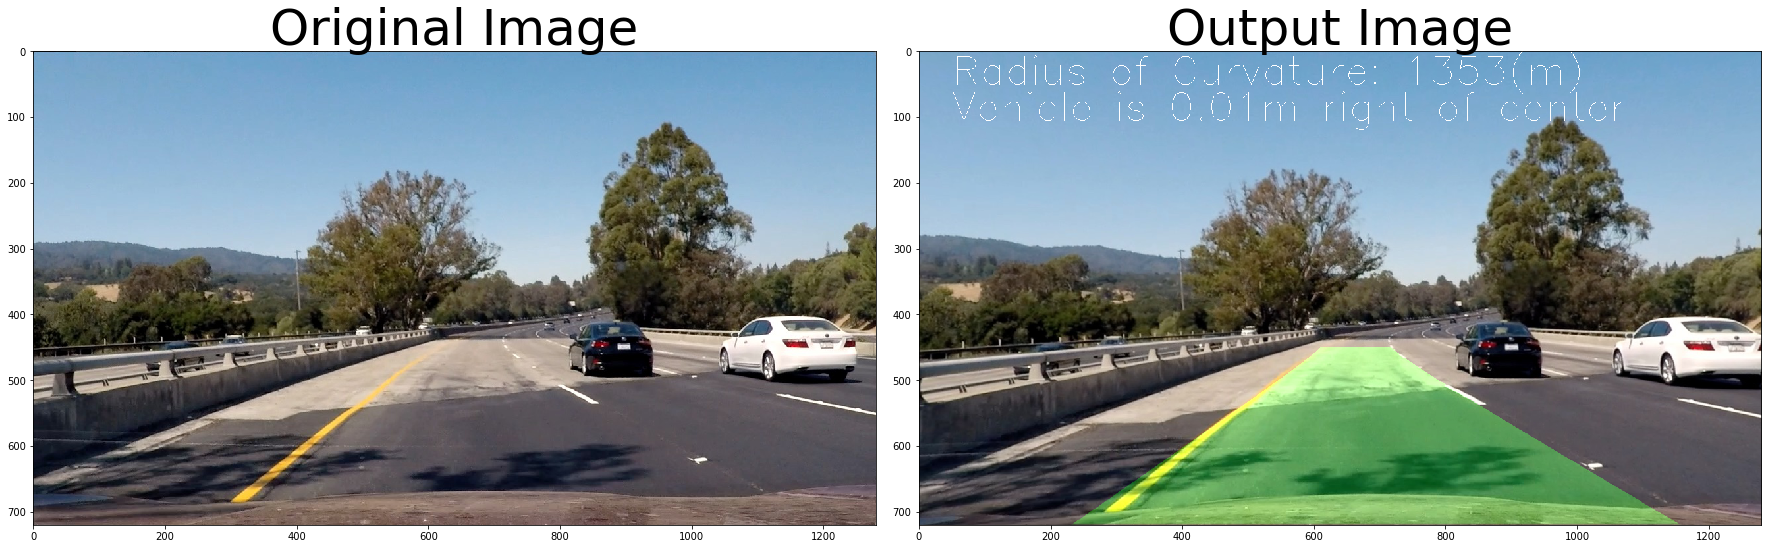

In [15]:
img_rgb = cv2.cvtColor(cv2.imread('test_images/test4.jpg'), cv2.COLOR_BGR2RGB)
img_out = pipeline(img_rgb)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_out)
ax2.set_title('Output Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test on Video

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #reading in an image

    return pipeline(image)

In [ ]:
which_video = 'project'
pipelineNum = 1

output = 'test_videos_output/{}_video_output_pipeline{}.mp4'.format(which_video, pipelineNum)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("{}_video.mp4".format(which_video)).subclip(10,15)
clip1 = VideoFileClip("{}_video.mp4".format(which_video))
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output_pipeline1.mp4
[MoviePy] Writing video test_videos_output/project_video_output_pipeline1.mp4


 95%|█████████▌| 1204/1261 [11:27<00:32,  1.75it/s]